# Importing Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading Dataset

In [36]:
df = pd.read_csv("Data.csv")
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [37]:
df.head()

,sender,subject,body,label
0,"""'FoRK'"" <fork@example.com>",Our friends Our servants,When settler goes postal kills Palestinians tr...,ham
1,Tom <tomwhore@slack.net>,boycotting yahoo,On 18 Sep Tom The others mailing list status A...,ham
2,Russell Turpin <deafbox@hotmail.com>,Selling Wedded Bliss,thank C On 7 Sep Russell Turpin Robert perfect...,ham
3,Tom <tomwhore@slack.net>,Adam dont job,On 4 Sep Tom A groys gesheft zol er hobn mit s...,ham
4,<Mike@dogma.slashnull.org>,Make Fortune On eBay 24772,eBay Rated Work Home Business Opportunity PC M...,spam


In [39]:
df.isnull().sum()

sender     156
subject    111
body       240
label        0
dtype: int64

In [40]:
df[df["body"].isnull()==True]

,sender,subject,body,label
8,"AGRICULTURE@dogma.slashnull.org, SPAIN.TXT@dog...",NEW TECHNOLOGY DIGITAL VIDEO RECORDER IP,NaN,spam
55,"Robert Elz <kre@munnari.OZ.AU>, exmh-workers@e...",New Sequences Window,NaN,ham
65,<zzzz@jmason.org>,Pru UL Portfolio Rocks,NaN,spam
81,<zzzz@jmason.org>,Impaired Risk Case Month,NaN,spam
89,razor-users@example.sourceforge.net,UUnet North American Backbone Problems 2 PDT,NaN,ham
...,...,...,...,...
2801,yyyy@example.com,Family refuses cancel expensive wedding groom ...,NaN,ham
2802,yyyy@example.com,Bush orders Sharon obey UN resolutions US gath...,NaN,ham
2805,yyyy@example.com,Giant otter statue built,NaN,ham
2811,yyyy@example.com,Truck driver leaves trail smelly pizza waste a...,NaN,ham


In [41]:
x = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values

# Encoding Class Label

In [62]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [63]:
print("No. of hams = {}".format(len(y[y==0])))
print("No. of spams = {}".format(len(y[y==1])))

No. of hams = 2410
No. of spams = 417


# Splitting Dataset

In [64]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

# String Vectorizing

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
cv_subject = CountVectorizer()
cv_body = CountVectorizer()
subject_vector_train = cv_subject.fit_transform(x_train[:,0].astype(str)).toarray()
body_vector_train = cv_body.fit_transform(x_train[:,1].astype(str)).toarray()
subject_vector_test = cv_subject.transform(x_test[:,0].astype(str)).toarray()
body_vector_test = cv_body.transform(x_test[:,1].astype(str)).toarray()

In [66]:
print(subject_vector_train.shape)
body_vector_train.shape

(2261, 2724)


(2261, 17549)

# Building New Training Set After Vectorizing

In [67]:
x_train = np.concatenate((subject_vector_train,body_vector_train),axis =1)
x_test = np.concatenate((subject_vector_test,body_vector_test),axis =1)

In [68]:
x_train.shape

(2261, 20273)

# Visualizing The Imbalance Dataset

In [69]:
v, c = np.unique(y, return_counts = True)

In [70]:
print("no of rows in class hams = {}".format(c[0]))
print("no of rows in class spams = {}".format(c[1]))

no of rows in class hams = 2410
no of rows in class spams = 417


([<matplotlib.axis.XTick at 0x7f9ec20d7d00>,
 [Text(0, 0, 'Not Spam'), Text(1, 0, 'Spam')])

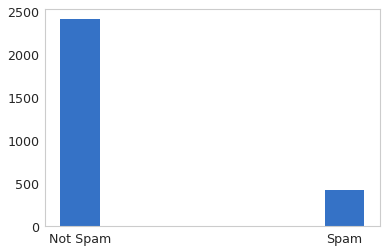

In [71]:
ind = np.arange(len(v))
ham_height = c[0]
spam_height = c[1]
plt.grid()
plt.bar(ind, [ham_height, spam_height], width = 0.15)
plt.xticks((0,1), ('Not Spam',"Spam"))

# Balancing The Minority By Oversampling

In [72]:
from imblearn.over_sampling import SMOTE
sampler = SMOTE()
x_train_over, y_train_over = sampler.fit_resample(x_train,y_train)

# Visualizing The Balanced Dataset

In [73]:
v, new_c = np.unique(y_train_over, return_counts=True)
print("no of rows in class hams = {}".format(new_c[0]))
print("no of rows in class spams = {}".format(new_c[1]))

no of rows in class hams = 1931
no of rows in class spams = 1931


([<matplotlib.axis.XTick at 0x7f9ec219cc10>,
 [Text(0, 0, 'Not Spam'), Text(1, 0, 'Spam')])

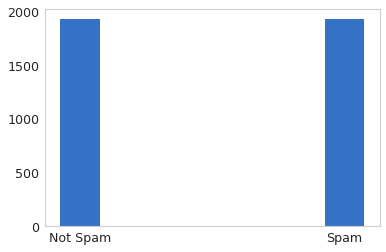

In [74]:
ind = np.arange(len(v))
ham_height = new_c[0]
spam_height = new_c[1]
plt.grid()
plt.bar(ind, [ham_height, spam_height], width = 0.15)
plt.xticks(ind, ('Not Spam',"Spam"))

# Building, Training The Model

In [75]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train_over, y_train_over)
y_pred = classifier.predict(x_test)

# Testing The Model Prediction

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[467  12]
 [ 26  61]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       479
           1       0.84      0.70      0.76        87

    accuracy                           0.93       566
   macro avg       0.89      0.84      0.86       566
weighted avg       0.93      0.93      0.93       566



# Testing Using K-fold Cross Validation

In [77]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,X = x_train_over, y = y_train_over, cv =10)

In [78]:
print("Average Accuracy : {:.02f} %".format(accuracies.mean()*100))
print("Accuracy std : {:.02f} %".format(accuracies.std()*100))

Average Accuracy : 96.92 %
Accuracy std : 4.07 %


# Prediction Result

In [79]:
print(le.inverse_transform(y_pred))

['ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham'
 'ham' 'spam' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'spam' 'spam' 'spam' 'ham' 'ham' 'ham' 'spam'
 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'spam'
 'ham' 'spam' 'ham' 'spam' 'ham' 'ham' 'spam' 'spam' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'spam' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham'
 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'h

array(['ham', 'ham', 'ham', ..., 'spam', 'spam', 'spam'], dtype=object)